<a href="https://colab.research.google.com/github/anmolkhurana490/Yoga-Posture-Recognition-and-Correction-System/blob/main/ai_yoga_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import random

In [2]:
import mediapipe as mp
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

def extract_zip(dir_name):
  # Replace with the actual path to your zip file in Google Drive
  zip_file_path = f'/content/drive/MyDrive/AI yoga trainer/large_dataset/{dir_name}.zip'
  # Replace with the desired extraction location in Colab
  extract_path = f'/content/large_dataset/{dir_name}'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully unzipped {zip_file_path} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

for dir_name in ['train', 'val', 'test']:
  extract_zip(dir_name)

Successfully unzipped /content/drive/MyDrive/AI yoga trainer/large_dataset/train.zip to /content/large_dataset/train
Successfully unzipped /content/drive/MyDrive/AI yoga trainer/large_dataset/val.zip to /content/large_dataset/val
Successfully unzipped /content/drive/MyDrive/AI yoga trainer/large_dataset/test.zip to /content/large_dataset/test


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
train_dir = '/content/large_dataset/train'
validation_dir = '/content/large_dataset/val'
test_dir = '/content/large_dataset/test'

In [7]:
mpPose=mp.solutions.pose
mpDraw=mp.solutions.drawing_utils
pose=mpPose.Pose(min_detection_confidence=0.7)

In [8]:
img=tf.io.read_file('/content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_77.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

(-0.5, 558.5, 305.5, -0.5)

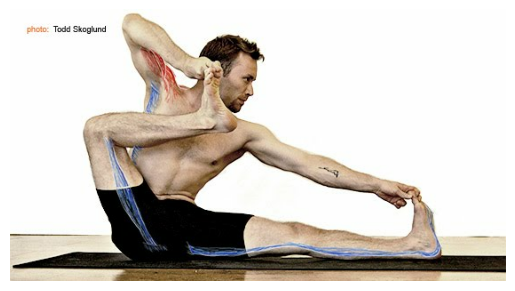

In [9]:
plt.imshow(img.numpy())
plt.axis('off')

In [10]:
# Rotate a point in 3D space by point (a,b,c)
def rotate_point(point, angles, arbitrary_point):
    """
    Rotate point (x,y,z) around pivot (a,b,c) by:
      - alpha around X-axis
      - beta  around Y-axis
      - gamma around Z-axis
    Angles in radians.
    Returns (x', y', z').
    """

    x, y, z = point
    a, b, c = arbitrary_point
    alpha, beta, gamma = angles

    ca, sa = math.cos(alpha), math.sin(alpha)
    cb, sb = math.cos(beta), math.sin(beta)
    cg, sg = math.cos(gamma), math.sin(gamma)

    x_prime = cg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) - sg*(ca*(y - b) - sa*(z - c)) + a
    y_prime = sg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) + cg*(ca*(y - b) - sa*(z - c)) + b
    z_prime = -sb*(x - a) + cb*(sa*(y - b) + ca*(z - c)) + c

    return x_prime, y_prime, z_prime

In [11]:
def visualize_landmarks(image_path):
  mp_drawing = mp.solutions.drawing_utils
  mp_pose = mp.solutions.pose

  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
      # Draw landmarks on the image
      annotated_image = image.copy()
      mp_drawing.draw_landmarks(
          annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

      # Display the annotated image using Matplotlib
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
      plt.title("Pose Landmarks")
      plt.axis('off')  # Hide axes
      plt.show()
    else:
      print("No pose landmarks detected in the image.")

In [12]:
len(results.pose_landmarks.landmark)
# print(results.pose_landmarks.landmark)

33

(-0.5, 558.5, 305.5, -0.5)

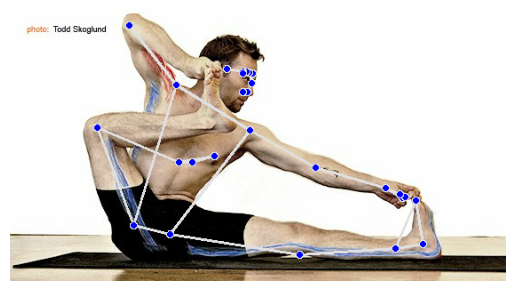

In [13]:
annonated_image = img.numpy().copy()
mpDraw.draw_landmarks(annonated_image, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
plt.imshow(annonated_image)
plt.axis('off')

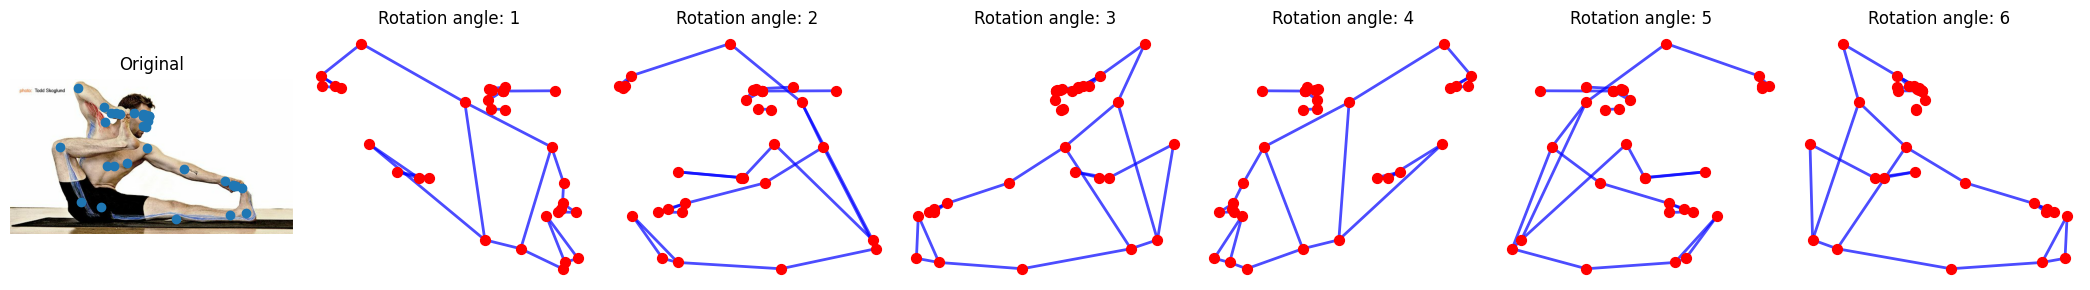

In [14]:
fig, axes = plt.subplots(1, 7, figsize=(21, 3)) # 7 subplots in one row

original_img_np = img.numpy().copy()
axes[0].imshow(original_img_np)
axes[0].scatter([landmark.x*len(img[0]) for landmark in results.pose_landmarks.landmark], [landmark.y*len(img) for landmark in results.pose_landmarks.landmark])
axes[0].set_title("Original")
axes[0].axis('off')

angles_list = [1,2,3,4,5,6]

for i, angle in enumerate(angles_list):
  rotated_img_np = img.numpy().copy()
  angles = (0, angle, 0) # Assuming rotation around Y-axis for visualization

  rotated_landmarks = [rotate_point((landmark.x, landmark.y, landmark.z), angles, (0.5, 0.5, 0)) for landmark in results.pose_landmarks.landmark]

  x_coords = [point[0] for point in rotated_landmarks]
  y_coords = [point[1] for point in rotated_landmarks]
  z_coords = [point[2] for point in rotated_landmarks]

  connections = mpPose.POSE_CONNECTIONS
  for connection in connections:
    start_idx, end_idx = connection
    axes[i+1].plot([x_coords[start_idx], x_coords[end_idx]],
                [y_coords[start_idx], y_coords[end_idx]],
                'blue', linewidth=2, alpha=0.7)

  # Draw landmarks
  axes[i+1].scatter(x_coords, y_coords, c='red', s=50, zorder=5)

  # axes[i+1].imshow(rotated_img_np)
  axes[i+1].invert_yaxis()
  axes[i+1].set_title(f"Rotation angle: {angle}")
  axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [15]:
classes = np.unique(os.listdir(validation_dir))
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 82


In [ ]:
classes

In [16]:
label_lookup = tf.keras.layers.StringLookup(
    vocabulary = classes,
    mask_token = None,
    num_oov_indices = 0
)

In [23]:
def apply_noise_augmentation(keypoints, noise_factor=0.02):
    """
    Add small random noise to keypoints
    """
    noise = np.random.normal(0, noise_factor, keypoints.shape)
    return keypoints + noise

def apply_scale_augmentation(keypoints, scale_range=(0.9, 1.1)):
    """
    Apply random scaling to keypoints
    """
    scale = random.uniform(scale_range[0], scale_range[1])
    center = np.mean(keypoints, axis=0)
    return center + (keypoints - center) * scale

def comprehensive_augmentation(keypoints, num_augmentations=5):
    """
    Apply comprehensive augmentation including rotation, noise, and scaling
    """
    augmented_keypoints = []

    # Original keypoints
    augmented_keypoints.append(keypoints)

    # # Calculate center point (hip center as pivot)
    # left_hip = keypoints[23]  # Left hip landmark
    # right_hip = keypoints[24]  # Right hip landmark
    # center_point = (left_hip + right_hip) / 2
    center_point = np.mean(keypoints, axis=0)

    for _ in range(num_augmentations):
        # Apply Rotation Augmentation
        # Angles are in radians.
        alpha = random.uniform(-0.5, 0.5) # approx -28 to 28 degrees
        beta = random.uniform(-1.5, 1.5) # approx -86 to 86 degrees
        gamma = random.uniform(-0.3, 0.3) # approx -17 to 17 degrees
        angles = (alpha, beta, gamma)

        rotated_keypoints = [rotate_point(point, angles, center_point) for point in keypoints]
        current_keypoints = np.array(rotated_keypoints)

        # Apply noise
        current_keypoints = apply_noise_augmentation(current_keypoints, noise_factor=0.015)

        # Apply scaling
        current_keypoints = apply_scale_augmentation(current_keypoints, scale_range=(0.95, 1.05))

        augmented_keypoints.append(current_keypoints)

    return augmented_keypoints

In [24]:
tf.data.experimental.enable_debug_mode()
def process_image_with_augmentation(image_path, num_augment):
  label = tf.strings.split(image_path, os.sep)[-2]
  encoded_label = label_lookup(label)

  img = tf.io.read_file(image_path)

  try:
    img = tf.image.decode_jpeg(img, channels=3)
  except:
    return np.zeros((0,3)), encoded_label

  img = tf.image.resize(img, [128, 128])

  def extract_features(img):
    features_list = []
    img = tf.cast(img, dtype=tf.uint8).numpy()

    results = pose.process(img)
    if results.pose_landmarks:
      features = []
      for landmark in results.pose_landmarks.landmark:
        features.append([landmark.x, landmark.y, landmark.z])
      features = np.array(features)

      # Apply comprehensive augmentation
      augmented_keypoints_list = comprehensive_augmentation(
        features, num_augmentations=num_augment
      )

      # Convert to the format expected by the model
      for keypoints in augmented_keypoints_list:
        features_list.append(keypoints)

      return np.array(features_list)
    else:
      return np.zeros((0,3))

  features = tf.py_function(extract_features, [img], [tf.float32])
  return features, encoded_label

def split_points(features, labels):
  features = tf.reshape(features, [-1, 33, 3])
  labels = tf.repeat(labels, tf.shape(features)[0])
  return tf.data.Dataset.from_tensor_slices((features, labels))

def extract_keypoints_dataset_with_augmentation(path, num_augment=0):
  dataset = tf.data.Dataset.list_files(f'{path}/*/*', shuffle=False)

  processed_dataset = dataset.map(
    lambda x: process_image_with_augmentation(x, num_augment),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  processed_dataset = processed_dataset.filter(lambda x,y: tf.shape(x)[1]>0)  # Remove out None values
  processed_dataset = processed_dataset.flat_map(split_points)  # Flatten the dataset
  return processed_dataset

In [25]:
train_dataset = extract_keypoints_dataset_with_augmentation(train_dir, 10).shuffle(1000).cache()
for data in train_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(1, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(1, shape=(), dtype=int64)


In [26]:
validation_dataset = extract_keypoints_dataset_with_augmentation(validation_dir).cache()
for data in validation_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)


In [27]:
test_dataset = extract_keypoints_dataset_with_augmentation(test_dir).cache()
for data in test_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (33, 3) Label: tf.Tensor(0, shape=(), dtype=int64)


In [30]:
# Compute Class Weights to Handle Imbalanced Dataset
import collections

# Iterate through the training dataset to count class occurrences
class_counts = collections.Counter()
for _, label in train_dataset:
    class_counts[label.numpy()] += 1
    # print(f"Iteration for {label.numpy()} completed")

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate class weights
# inversely proportional to the class frequencies
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}

print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: Counter({57: 3707, 39: 2541, 60: 2486, 72: 2354, 30: 2211, 21: 2090, 22: 2068, 58: 2068, 6: 2035, 56: 2035, 2: 2002, 9: 1991, 63: 1980, 65: 1925, 8: 1881, 69: 1881, 74: 1881, 3: 1870, 17: 1848, 77: 1815, 47: 1727, 31: 1705, 5: 1683, 28: 1650, 40: 1617, 68: 1584, 64: 1573, 4: 1562, 13: 1562, 66: 1562, 51: 1496, 12: 1463, 49: 1452, 37: 1430, 23: 1375, 71: 1342, 38: 1298, 55: 1265, 76: 1265, 36: 1254, 26: 1188, 52: 1177, 10: 1166, 73: 1155, 19: 1122, 24: 1111, 32: 1111, 62: 1111, 81: 1111, 78: 1078, 75: 1067, 11: 1034, 29: 1034, 18: 979, 34: 979, 45: 968, 7: 946, 50: 946, 79: 946, 35: 924, 25: 913, 48: 891, 61: 847, 27: 825, 33: 825, 46: 770, 14: 715, 53: 693, 42: 605, 1: 583, 0: 517, 67: 495, 59: 484, 44: 473, 20: 440, 80: 440, 54: 418, 16: 396, 43: 352, 70: 308, 15: 231, 41: 198})
Class weights: {0: 2.502854177477945, 1: 2.2195121951219514, 2: 0.6463414634146342, 3: 0.6919655667144907, 4: 0.8284094812779114, 5: 0.7688506296827674, 6: 0.6358602504943969, 7: 1.36783891094724

In [31]:
train_dataset = train_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()
validation_dataset = validation_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()

In [32]:
# # Image data generators
# train_datagen = ImageDataGenerator(rescale=1.0/255.0,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(150, 150),
#                                                     batch_size=32,
#                                                     class_mode='categorical')

# validation_generator = validation_datagen.flow_from_directory(validation_dir,
#                                                               target_size=(150, 150),
#                                                               batch_size=32,
#                                                               class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=(150, 150),
#                                                   batch_size=32,
#                                                   class_mode='categorical',
#                                                   shuffle=False)

In [76]:
model = Sequential([
    Input(shape=(33, 3)),
    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=450,
    validation_data=validation_dataset,
    validation_steps=65,
    class_weight=class_weights
)

In [55]:
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test accuracy: {test_acc}")
model.save('yoga_trainer_model.keras')

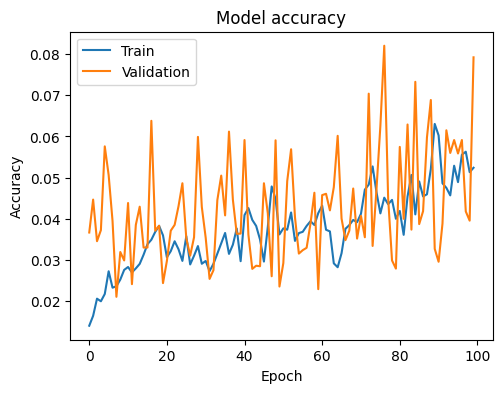

In [74]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

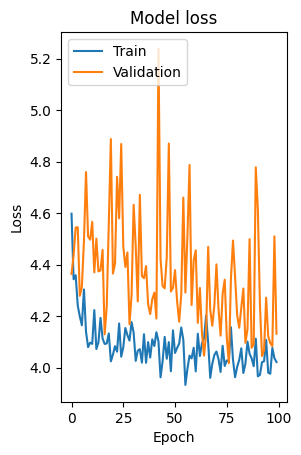

In [75]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [64]:
loss, accuracy = model.evaluate(test_dataset, steps=7)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.1537 - loss: 3.4548 
Test Loss: 3.6422595977783203
Test Accuracy: 0.12208972126245499


In [65]:
img=tf.io.read_file('/content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_76.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

In [66]:
features=[[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
ypred=model.predict(np.array([features])).argmax(axis=1)
print('Pose Predicted:', label_lookup.get_vocabulary()[ypred[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Pose Predicted: Half_Moon_Pose_or_Ardha_Chandrasana_


In [ ]:
label_lookup.save_assets('label_lookup_')